# Data Preprocessing and EDA（彭）

In [1]:
# Data preprocessing
# ==============================================
# UCI Default of Credit Card Clients
# Data Cleaning & Standardization  + Derived Features
# ==============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- 讀取資料 ---
encodings = ["utf-8", "utf-8-sig", "latin1", "cp1252", "big5", "cp950"]
df = None
for enc in encodings:
    try:
        df = pd.read_csv("./data/default of credit card clients.csv", header=1, encoding=enc, engine="python")
        print(f"成功使用編碼：{enc}")
        break
    except Exception as e:
        print(f"嘗試 {enc} 失敗：{e}")

if df is None:
    raise RuntimeError("無法讀取 CSV，請確認檔案編碼格式")

# --- 移除非特徵欄位 ---
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

TARGET_COL = "default payment next month"

# --- 類別欄位修正 ---
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})  # 教育=其他
df["MARRIAGE"] = df["MARRIAGE"].replace({0: 3})                # 婚姻=其他
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    df[col] = df[col].astype("category")

# --- 去除重複列 ---
before = len(df)
df = df.drop_duplicates()
print(f"移除重複列：{before - len(df)}")
print(len(df))

# --- 額外清理：PAY 欄位中的 -2 合併為 -1 ---
pay_cols = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
df[pay_cols] = df[pay_cols].replace(-2, -1)

# =========================
# 衍生特徵（Derived Features）
# =========================
bill_cols   = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
payamt_cols = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

# 1) 信用使用率（最近一期）：帳單餘額 / 額度（上界1）
df["CREDIT_UTILIZATION"] = (df["BILL_AMT1"] / df["LIMIT_BAL"]).clip(lower=0).clip(upper=1)

# 2) 平均繳款率（六期總繳款 / 六期總帳單）(跟PAY_TO_BILL_RATIO相同 留PAY_TO_BILL_RATIO)
total_bill = df[bill_cols].replace(0, np.nan).sum(axis=1)
total_pay  = df[payamt_cols].sum(axis=1)
# df["PAYMENT_RATIO_MEAN"] = (total_pay / total_bill).replace([np.inf, -np.inf], np.nan).fillna(0)

# 3) 帳單金額變化（六期相鄰差的平均絕對值）
df["BILL_CHANGE_MEAN"] = df[bill_cols].diff(axis=1).abs().mean(axis=1)

# 4) 最嚴重延遲（月數最大值，-1 代表準時，1~9 代表延遲月數）
df["MAX_DELAY"] = df[pay_cols].max(axis=1)

# 5) 最近一次延遲（月數：即 PAY_0）
df["LAST_DELAY"] = df["PAY_0"]

# 6) 最近一期繳款比例（PAY_AMT1 / BILL_AMT1）
df["RECENT_PAY_RATIO"] = (df["PAY_AMT1"] / df["BILL_AMT1"]).replace([np.inf, -np.inf], np.nan).fillna(0)

# 7) 繳款一致性（六期繳款金額的標準差）
df["PAYMENT_STD"] = df[payamt_cols].std(axis=1)

# 8) 六期總帳單 / 總繳款 與 長期繳清率
df["TOTAL_BILL"] = total_bill.fillna(0)    # 若六期帳單全為 0，視為 0
df["TOTAL_PAY"]  = total_pay
df["PAY_TO_BILL_RATIO"] = (df["TOTAL_PAY"] / df["TOTAL_BILL"]).replace([np.inf, -np.inf], np.nan).fillna(0)

# --- 變數註解（for README / schema 用） ---
variable_notes = {
    # 原始欄位
    "LIMIT_BAL": "給定信用額度（包含個人與家庭額度），單位：新台幣",
    "SEX": "性別（1 = 男性，2 = 女性）",
    "EDUCATION": "教育程度（1 = 研究所，2 = 大學，3 = 高中，4 = 其他）",
    "MARRIAGE": "婚姻狀況（1 = 已婚，2 = 單身，3 = 其他）",
    "AGE": "年齡（年）",
    "PAY_0": "Sep 2005 還款狀態 (-1 = 準時付款，0 = 無延遲，1~9 = 延遲月數)",
    "PAY_2": "Aug 2005 還款狀態",
    "PAY_3": "Jul 2005 還款狀態",
    "PAY_4": "Jun 2005 還款狀態",
    "PAY_5": "May 2005 還款狀態",
    "PAY_6": "Apr 2005 還款狀態",
    "BILL_AMT1": "Sep 2005 帳單金額（單位：新台幣）",
    "BILL_AMT2": "Aug 2005 帳單金額",
    "BILL_AMT3": "Jul 2005 帳單金額",
    "BILL_AMT4": "Jun 2005 帳單金額",
    "BILL_AMT5": "May 2005 帳單金額",
    "BILL_AMT6": "Apr 2005 帳單金額",
    "PAY_AMT1": "Sep 2005 實際繳款金額（單位：新台幣）",
    "PAY_AMT2": "Aug 2005 實際繳款金額",
    "PAY_AMT3": "Jul 2005 實際繳款金額",
    "PAY_AMT4": "Jun 2005 實際繳款金額",
    "PAY_AMT5": "May 2005 實際繳款金額",
    "PAY_AMT6": "Apr 2005 實際繳款金額",
    "default payment next month": "是否在下個月發生違約（1 = 違約，0 = 正常）",

    # 衍生特徵（Derived）
    " CREDIT_UTILIZATION": "[Derived] 信用使用率（最近一期）：BILL_AMT1 / LIMIT_BAL，截斷於 [0,1]（0 = 未使用額度，1 = 額度全滿）",
    " BILL_CHANGE_MEAN": "[Derived] 帳單變化程度：六期相鄰帳單差的平均絕對值（數值越大 = 消費波動越大）",
    " MAX_DELAY": "[Derived] 最嚴重延遲月數：PAY_0~PAY_6 的最大值（-1 = 準時或無應付款；0 = 無延遲；1~9 = 延遲 N 月）",
    " LAST_DELAY": "[Derived] 最近一期延遲月數：PAY_0（-1 = 準時或無應付款；0 = 無延遲；1~9 = 延遲 N 月）",
    " RECENT_PAY_RATIO": "[Derived] 最近一期繳款比例：PAY_AMT1 / BILL_AMT1，無帳單則為 0（>1 = 溢繳）",
    " PAYMENT_STD": "[Derived] 繳款一致性：六期繳款金額的標準差（數值越高 = 繳款波動越大）",
    " TOTAL_BILL": "[Derived] 六期帳單總額（BILL_AMT1~6 加總）（反映近半年消費總量）",
    " TOTAL_PAY": "[Derived] 六期繳款總額（PAY_AMT1~6 加總）（反映近半年還款總額）",
    " PAY_TO_BILL_RATIO": "[Derived] 長期繳清率：TOTAL_PAY / TOTAL_BILL，無帳單則為 0（>1 = 長期溢繳）"
}

# --- 標準化數值欄位（訓練時項目間數值會差異太大 因此先做） ---
cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
num_cols = [c for c in df.columns if c not in cat_cols + [TARGET_COL]]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

# --- 輸出檔案 ---
df.to_csv("./result/uci_default_cleaned.csv", index=False)
df_scaled.to_csv("./result/uci_default_cleaned_scaled.csv", index=False)

schema = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "description": [variable_notes.get(c, "") for c in df.columns]
})
schema.to_csv("./result/uci_default_schema.csv", index=False)

with open("./result/uci_default_README.txt", "w", encoding="utf-8") as f:
    f.write("UCI Default of Credit Card Clients — 資料清理說明\n")
    f.write("--------------------------------------------------\n")
    f.write("此資料集用於信用風險模型，目標為預測客戶下個月是否發生信用卡違約。\n")
    f.write("原始資料共 30,000 筆，經清理後移除 35 筆重複資料，最終保留 29,965 筆樣本。\n")
    f.write("目標欄位為「default payment next month」（1 = 違約，0 = 正常）。\n\n")

    f.write("[主要處理步驟]\n")
    f.write("1. 移除 ID 欄位（僅為識別用，與違約行為無關）。\n")
    f.write("2. 修正 EDUCATION (0,5,6→4)；MARRIAGE (0→3)：將非法值 0、5、6 合併為 4（其他類別）。\n")
    f.write("3. 將 SEX、EDUCATION、MARRIAGE 轉為類別型態（category），以利後續 one-hot 編碼。\n")
    f.write("4. PAY_0～PAY_6 欄位中出現的 -2 值，代表「該期無應付款或帳單已結清」，故合併為 -1（視為按時付款或無需付款）。\n")
    f.write("5. 新增衍生特徵（Derived Features）：\n")
    f.write("   - CREDIT_UTILIZATION：最近一期信用使用率（BILL_AMT1 / LIMIT_BAL，截斷於 [0,1]）。\n")
    f.write("   - BILL_CHANGE_MEAN：六期帳單變化程度（相鄰差的平均絕對值）。\n")
    f.write("   - MAX_DELAY：最嚴重延遲月數（PAY_0~PAY_6 的最大值）。\n")
    f.write("   - LAST_DELAY：最近一期延遲月數（PAY_0）。\n")
    f.write("   - RECENT_PAY_RATIO：最近一期繳款比例（PAY_AMT1 / BILL_AMT1，無帳單時為 0）。\n")
    f.write("   - PAYMENT_STD：六期繳款金額的標準差（繳款一致性）。\n")
    f.write("   - TOTAL_BILL：六期帳單總額。\n")
    f.write("   - TOTAL_PAY：六期繳款總額。\n")
    f.write("   - PAY_TO_BILL_RATIO：長期繳清率（TOTAL_PAY / TOTAL_BILL，無帳單時為 0）。\n")
    f.write("6. 標準化數值欄位（建立 scaled 版本）（適用 Logistic Regression、SVM、Neural Network）。\n\n")

    f.write("[輸出檔案]\n")
    f.write("- uci_default_cleaned.csv：未標準化版本（適用於 Random Forest、XGBoost、CatBoost 等樹模型）。\n")
    f.write("- uci_default_cleaned_scaled.csv：標準化版本（適用於 Logistic Regression、SVM、Neural Network）。\n")
    f.write("- uci_default_schema.csv：欄位型態與描述（含原始欄位與 [Derived] 衍生特徵）。\n\n")

    f.write("[欄位說明]\n")
    f.write("以下依據 Yeh & Lien (2009) 定義與本研究新增特徵進行整理；標記為 [Derived] 者為本研究衍生特徵：\n")
    for k, v in variable_notes.items():
        f.write(f"- {k}: {v}\n")

    f.write("\n所有 derived features 均經過 Winsorization（1% ~ 99%）檢查，無極端值異常。")

print("輸出完成：uci_default_cleaned.csv, uci_default_cleaned_scaled.csv, uci_default_schema.csv, uci_default_README.txt")


嘗試 utf-8 失敗：[Errno 2] No such file or directory: './data/default of credit card clients.csv'
嘗試 utf-8-sig 失敗：[Errno 2] No such file or directory: './data/default of credit card clients.csv'
嘗試 latin1 失敗：[Errno 2] No such file or directory: './data/default of credit card clients.csv'
嘗試 cp1252 失敗：[Errno 2] No such file or directory: './data/default of credit card clients.csv'
嘗試 big5 失敗：[Errno 2] No such file or directory: './data/default of credit card clients.csv'
嘗試 cp950 失敗：[Errno 2] No such file or directory: './data/default of credit card clients.csv'


RuntimeError: 無法讀取 CSV，請確認檔案編碼格式

,count,mean,std,min,max
LIMIT_BAL,29965.0,167442.005006,129760.135222,10000.000000,1.000000e+06
SEX,29965.0,1.603738,0.489128,1.000000,2.000000e+00
EDUCATION,29965.0,1.842750,0.744513,1.000000,4.000000e+00
MARRIAGE,29965.0,1.557283,0.521431,1.000000,3.000000e+00
AGE,29965.0,35.487969,9.219459,21.000000,7.900000e+01
PAY_0,29965.0,0.075021,0.990735,-1.000000,8.000000e+00
PAY_2,29965.0,-0.006641,1.035798,-1.000000,8.000000e+00
PAY_3,29965.0,-0.029067,1.024849,-1.000000,8.000000e+00
PAY_4,29965.0,-0.074821,0.987241,-1.000000,8.000000e+00
PAY_5,29965.0,-0.113799,0.941698,-1.000000,8.000000e+00


違約率(Default Rate): 22.13%


,Target,Count,Percent
0,0,23335,77.874187
1,1,6630,22.125813


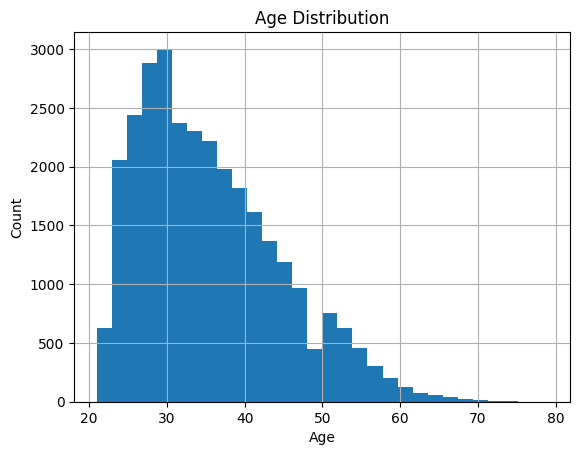

,SEX,Count,Percent,Default Rate
0,1,11874,39.63%,24.16%
1,2,18091,60.37%,20.79%


,EDUCATION,Count,Percent,Default Rate
0,1,10563,35.25%,19.24%
1,2,14019,46.78%,23.74%
2,3,4915,16.40%,25.17%
3,4,468,1.56%,7.05%


,MARRIAGE,Count,Percent,Default Rate
0,1,13643,45.53%,23.46%
1,2,15945,53.21%,20.95%
2,3,377,1.26%,23.61%


,AGE_GROUP,Count,Percent,Default Rate
0,20–29,9603,32.05%,22.87%
1,30–39,11226,37.46%,20.27%
2,40–49,6456,21.55%,22.94%
3,50–59,2341,7.81%,24.86%
4,60–69,314,1.05%,28.34%
5,70+,25,0.08%,28.00%



=== PAY_0 vs Default Rate ===


,PAY_0,Count,Default Rate
0,-1,8432,15.630930
1,0,14737,12.811291
2,1,3667,34.033270
3,2,2666,69.129782
4,3,322,75.776398
5,4,76,68.421053
6,5,26,50.000000
7,6,11,54.545455
8,7,9,77.777778
9,8,19,57.894737



=== PAY_2 vs Default Rate ===


,PAY_2,Count,Default Rate
0,-1,9798,16.860584
1,0,15730,15.912270
2,1,28,17.857143
3,2,3926,55.603668
4,3,326,61.656442
5,4,99,50.505051
6,5,25,60.000000
7,6,12,75.000000
8,7,20,60.000000
9,8,1,0.000000



=== PAY_3 vs Default Rate ===


,PAY_3,Count,Default Rate
0,-1,9989,16.798478
1,0,15764,17.451155
2,1,4,25.000000
3,2,3819,51.557999
4,3,240,57.500000
5,4,75,57.333333
6,5,21,57.142857
7,6,23,60.869565
8,7,27,81.481481
9,8,3,66.666667



=== PAY_4 vs Default Rate ===


,PAY_4,Count,Default Rate
0,-1,10001,17.358264
1,0,16455,18.328775
2,1,2,50.000000
3,2,3159,52.326686
4,3,180,61.111111
5,4,68,66.176471
6,5,35,51.428571
7,6,5,40.000000
8,7,58,82.758621
9,8,2,50.000000



=== PAY_5 vs Default Rate ===


,PAY_5,Count,Default Rate
0,-1,10051,17.779325
1,0,16947,18.852894
2,2,2626,54.188880
3,3,178,63.483146
4,4,83,60.240964
5,5,17,58.823529
6,6,4,75.000000
7,7,58,82.758621
8,8,1,100.000000



=== PAY_6 vs Default Rate ===


,PAY_6,Count,Default Rate
0,-1,10601,18.403924
1,0,16286,18.844406
2,2,2766,50.650759
3,3,184,64.130435
4,4,48,62.500000
5,5,13,53.846154
6,6,19,73.684211
7,7,46,82.608696
8,8,2,100.000000


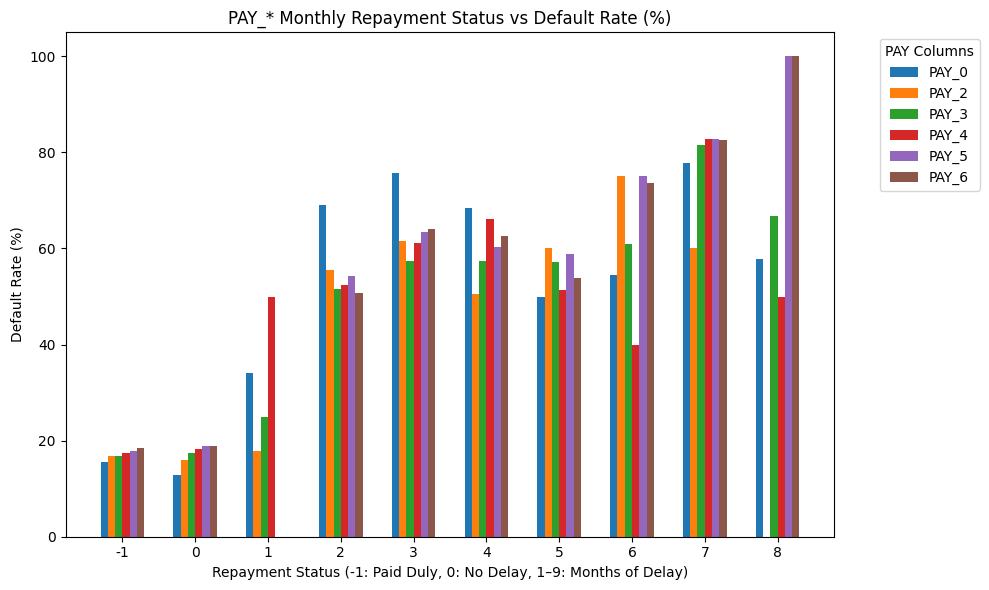

In [ ]:
# Origin data EDA
# ===========================================
# UCI Default Credit Card Clients - EDA
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# ---------- 讀取資料 ----------
df = pd.read_csv("./result/uci_default_cleaned.csv")
TARGET_COL = "default payment next month"

# ---------- (1) 各項目基本統計 ----------
summary_table = df.describe().T[["count", "mean", "std", "min", "max"]]
display(summary_table)

# ---------- (2) target分布（保留原版；你先前說 target 不用加 default rate） ----------
target_table = df[TARGET_COL].value_counts().rename_axis("Target").reset_index(name="Count")
target_table["Percent"] = target_table["Count"] / target_table["Count"].sum() * 100
target_rate = df[TARGET_COL].mean()
print(f"違約率(Default Rate): {target_rate:.2%}")
display(target_table)

# ---------- (3) SEX / EDUCATION / MARRIAGE / AGE 分布 ----------
# 3a) 三個類別欄位的分布表 (Count, Percent)
# for col in ["SEX", "EDUCATION", "MARRIAGE"]:
#     freq = df[col].value_counts().sort_index().rename_axis(col).reset_index(name="Count")
#     freq["Percent"] = freq["Count"] / freq["Count"].sum() * 100
#     display(freq)

# 3b) AGE 直方圖
plt.figure()
df["AGE"].hist(bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# 3c) AGE 分布（表格；使用分箱）
bins = [20,30,40,50,60,70,80]
labels = ["20–29","30–39","40–49","50–59","60–69","70+"]
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, labels=labels, right=False)
age_dist = df["AGE_GROUP"].value_counts().sort_index().rename_axis("AGE_GROUP").reset_index(name="Count")
age_dist["Percent"] = age_dist["Count"] / age_dist["Count"].sum() * 100
# display(age_dist)

# ---------- (4) 各類別的 Count / Percent / Default Rate（你要的重點） ----------
def category_summary_with_default_rate(col):
    total = len(df)
    grp = df.groupby(col)[TARGET_COL].agg(["count", "mean"]).rename(columns={"count":"Count", "mean":"Default Rate"})
    grp["Percent"] = grp["Count"] / total * 100
    grp = grp.reset_index()[[col, "Count", "Percent", "Default Rate"]]
    # 美化顯示
    grp["Percent"] = grp["Percent"].map("{:.2f}%".format)
    grp["Default Rate"] = (grp["Default Rate"]*100).map("{:.2f}%".format)
    display(grp)
    return grp

sex_table = category_summary_with_default_rate("SEX")
edu_table = category_summary_with_default_rate("EDUCATION")
marriage_table = category_summary_with_default_rate("MARRIAGE")
age_table = category_summary_with_default_rate("AGE_GROUP")

# （可選）輸出到 Excel 方便報告附錄
# with pd.ExcelWriter("./UCI/eda_category_summary.xlsx") as writer:
#     sex_table.to_excel(writer, sheet_name="SEX", index=False)
#     edu_table.to_excel(writer, sheet_name="EDUCATION", index=False)
#     marriage_table.to_excel(writer, sheet_name="MARRIAGE", index=False)
#     age_table.to_excel(writer, sheet_name="AGE_GROUP", index=False)

# ---------- (5) 各月份還款狀態（PAY_*）vs 違約率 ----------
pay_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
pay_rates = {}

# 計算各 PAY 欄位的違約率表格
for col in pay_cols:
    grp = df.groupby(col)[TARGET_COL].agg(["count","mean"]).rename(columns={"count":"Count","mean":"Default Rate"})
    grp["Default Rate"] = grp["Default Rate"] * 100
    grp = grp.reset_index()
    pay_rates[col] = grp
    print(f"\n=== {col} vs Default Rate ===")
    display(grp)

# 將所有 PAY 欄位的違約率整合成一張長條圖
plt.figure(figsize=(10,6))
offsets = np.linspace(-0.25, 0.25, num=len(pay_cols))
width = 0.1
all_x = sorted(set().union(*[df[c].dropna().unique().tolist() for c in pay_cols]))

for i, col in enumerate(pay_cols):
    grp = pay_rates[col].set_index(col)["Default Rate"]
    y_vals = [grp.get(x, np.nan) for x in all_x]
    y_vals = [0 if (v is np.nan or pd.isna(v)) else v for v in y_vals]
    xs = np.array(all_x, dtype=float) + offsets[i]
    plt.bar(xs, y_vals, width=width, label=col)
    # for x, y in zip(xs, y_vals):
    #     if y > 0:
    #         plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', va='bottom', fontsize=8)

plt.title("PAY_* Monthly Repayment Status vs Default Rate (%)")
plt.xlabel("Repayment Status (-1: Paid Duly, 0: No Delay, 1–9: Months of Delay)")
plt.ylabel("Default Rate (%)")
plt.xticks(ticks=all_x, labels=[str(int(x)) for x in all_x])
plt.legend(title="PAY Columns", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Derived data EDA
# ===========================================
# UCI Default Credit Card Clients - Derived Features Summary (Table)
# ===========================================
import pandas as pd
import numpy as np

# ---------- 讀取資料 ----------
df = pd.read_csv("./result/uci_default_cleaned.csv")
TARGET_COL = "default payment next month"

# ---------- 選擇衍生特徵 ----------
derived_cols = [
    "CREDIT_UTILIZATION",  # 信用使用率
    "PAY_TO_BILL_RATIO",   # 長期繳清率
    "BILL_CHANGE_MEAN",    # 帳單變化程度
    "PAYMENT_STD",         # 繳款一致性
    "MAX_DELAY",           # 最嚴重延遲月數
    "LAST_DELAY",          # 最近延遲月數
    "RECENT_PAY_RATIO",    # 最近一期繳款比例
    "TOTAL_BILL",          # 六期帳單總額
    "TOTAL_PAY"            # 六期繳款總額
]

# ---------- 統計摘要表格 ----------
summary_table = df[derived_cols].describe(percentiles=[.25, .5, .75]).T
summary_table = summary_table[["count", "mean", "std", "min", "max"]]
# summary_table.rename(columns={"50%": "median"}, inplace=True)

# ---------- 顯示表格 ----------
display(summary_table)



,count,mean,std,min,max
CREDIT_UTILIZATION,29965.0,0.415148,0.386960,0.000000,1.000000e+00
PAY_TO_BILL_RATIO,29965.0,0.381252,7.675470,-546.928571,7.970000e+02
BILL_CHANGE_MEAN,29965.0,7817.530886,13718.221494,0.000000,7.094932e+05
PAYMENT_STD,29965.0,5811.698835,15013.888412,0.000000,6.500983e+05
MAX_DELAY,29965.0,0.509227,1.237792,-1.000000,8.000000e+00
LAST_DELAY,29965.0,0.075021,0.990735,-1.000000,8.000000e+00
RECENT_PAY_RATIO,29965.0,-2.229884,231.253172,-35436.000000,1.145367e+04
TOTAL_BILL,29965.0,270175.968697,379674.444976,-336259.000000,5.263883e+06
TOTAL_PAY,29965.0,31687.783848,60853.841129,0.000000,3.764066e+06



=== MAX_DELAY — Default Rate by Bins ===


,bin,count,Default Rate (%)
0,-1,5182,14.22
1,0,14736,10.83
2,1,1668,25.06
3,2,7187,43.55
4,3,789,62.23
5,4,217,64.06
6,5,69,50.72
7,6,25,56.00
8,7,67,83.58
9,8,25,56.00


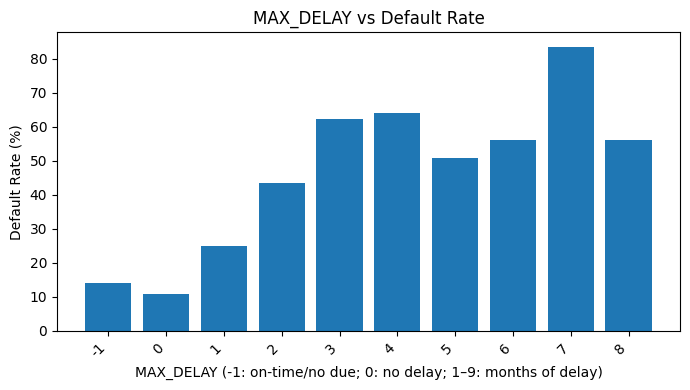


=== CREDIT_UTILIZATION — Default Rate by Bins ===


,bin,count,Default Rate (%)
0,"(-0.001, 0.1]",11207,18.78
1,"(0.1, 0.2]",2013,15.60
2,"(0.2, 0.3]",1538,18.40
3,"(0.3, 0.4]",1401,21.27
4,"(0.4, 0.5]",1432,23.74
5,"(0.5, 0.6]",1473,24.51
6,"(0.6, 0.7]",1379,26.54
7,"(0.7, 0.8]",1542,27.89
8,"(0.8, 0.9]",1932,28.11
9,"(0.9, 1.0]",6048,26.29


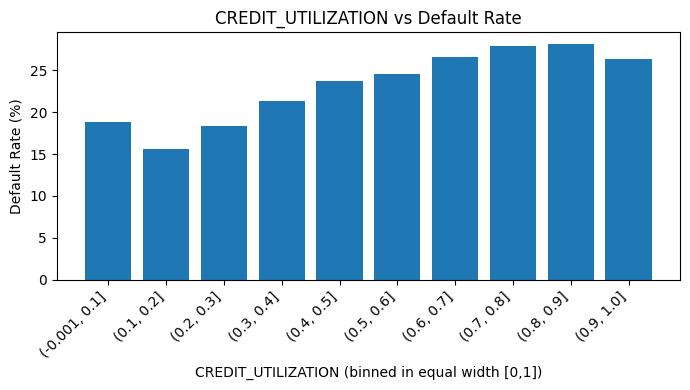


=== PAY_TO_BILL_RATIO — Default Rate by Bins ===


,bin,count,Default Rate (%)
0,"(-546.93, 0.0319]",2997,35.87
1,"(0.0319, 0.0384]",2996,25.63
2,"(0.0384, 0.0443]",2997,24.42
3,"(0.0443, 0.0558]",2996,25.37
4,"(0.0558, 0.0851]",2997,27.06
5,"(0.0851, 0.179]",2996,21.83
6,"(0.179, 0.416]",2996,15.39
7,"(0.416, 0.767]",2997,15.75
8,"(0.767, 1.0]",3067,15.36
9,"(1.0, 797.0]",2926,14.56


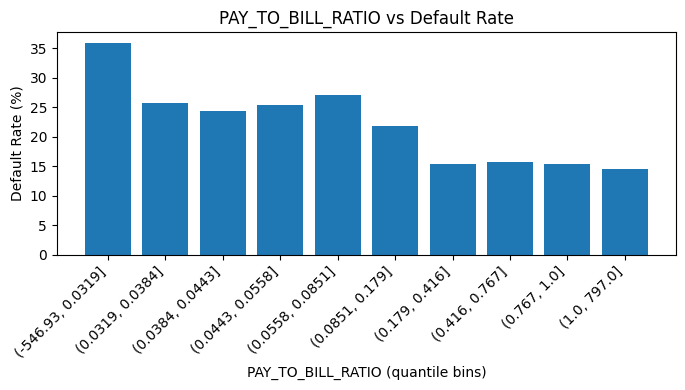

In [ ]:
# Derived data EDA plot
# ===========================================
# Three Key Derived Features — Default Rate by Bins
# (each feature: show table + plot separately)
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---- load ----
df = pd.read_csv("./result/uci_default_cleaned.csv")
TARGET_COL = "default payment next month"

# ---- helper: table + plot (matplotlib only) ----
def show_table_and_plot(feature, bins=None, use_qcut=False, csv_name=None, title=None, xlabel=None):
    """
    feature: 欄位名
    bins:    若提供，使用 pd.cut(bins)；否則 use_qcut=True 時用 qcut(10)
    use_qcut: 是否用分位數分箱
    csv_name: 匯出檔名
    """
    tmp = df[[feature, TARGET_COL]].dropna().copy()
    # binning
    if bins is not None:
        tmp["bin"] = pd.cut(tmp[feature], bins=bins, include_lowest=True)
    elif use_qcut:
        tmp["bin"] = pd.qcut(tmp[feature], q=10, duplicates="drop")
    else:
        # treat as categorical / discrete already
        tmp["bin"] = tmp[feature]

    # table: count + default rate
    tab = tmp.groupby("bin")[TARGET_COL].agg(["count", "mean"]).rename(columns={"mean":"Default Rate"})
    tab["Default Rate (%)"] = (tab["Default Rate"] * 100).round(2)
    tab = tab.drop(columns=["Default Rate"]).reset_index()

    # display table
    print(f"\n=== {feature} — Default Rate by Bins ===")
    display(tab)

    # save csv
    # if csv_name:
    #     tab.to_csv(csv_name, index=False, encoding="utf-8")
    #     print(f"✅ saved: {csv_name}")

    # plot (single chart, no seaborn, no color specified)
    plt.figure(figsize=(7,4))
    x_labels = [str(b) for b in tab["bin"]]
    x_pos = np.arange(len(x_labels))
    plt.bar(x_pos, tab["Default Rate (%)"].values)
    plt.xticks(x_pos, x_labels, rotation=45, ha="right") # for OTHER
    # plt.xticks(x_pos, x_labels, rotation=0, ha="center")  # for MAX_DELAY
    plt.ylabel("Default Rate (%)")
    plt.xlabel(xlabel if xlabel else feature)
    plt.title(title if title else f"{feature} vs Default Rate")
    plt.tight_layout()
    plt.show()


# 1) MAX_DELAY — 離散值：直接以原值分組
#    (-1=準時/無應付款, 0=無延遲, 1~9=延遲N月)
show_table_and_plot(
    feature="MAX_DELAY",
    bins=None,          # 不分箱，直接以離散值分組
    use_qcut=False,
    csv_name="./UCI/eda_MAX_DELAY_default_rate.csv",
    title="MAX_DELAY vs Default Rate",
    xlabel="MAX_DELAY (-1: on-time/no due; 0: no delay; 1–9: months of delay)"
)

# 2) CREDIT_UTILIZATION — 連續值：[0,1] 固定寬度分箱（可直接解讀使用率）
#    這裡用等寬 10 箱：0–0.1, 0.1–0.2, ... , 0.9–1.0
credit_bins = np.linspace(0, 1, 11)
show_table_and_plot(
    feature="CREDIT_UTILIZATION",
    bins=credit_bins,
    use_qcut=False,
    csv_name="./UCI/eda_CREDIT_UTILIZATION_default_rate.csv",
    title="CREDIT_UTILIZATION vs Default Rate",
    xlabel="CREDIT_UTILIZATION (binned in equal width [0,1])"
)

# 3) PAY_TO_BILL_RATIO — 連續值、長尾：用分位數分箱（每箱樣本數較均衡）
#    若想更穩定可改 q=8 或 q=12
show_table_and_plot(
    feature="PAY_TO_BILL_RATIO",
    bins=None,
    use_qcut=True,     # 10-quantile bins
    csv_name="./UCI/eda_PAY_TO_BILL_RATIO_default_rate.csv",
    title="PAY_TO_BILL_RATIO vs Default Rate",
    xlabel="PAY_TO_BILL_RATIO (quantile bins)"
)


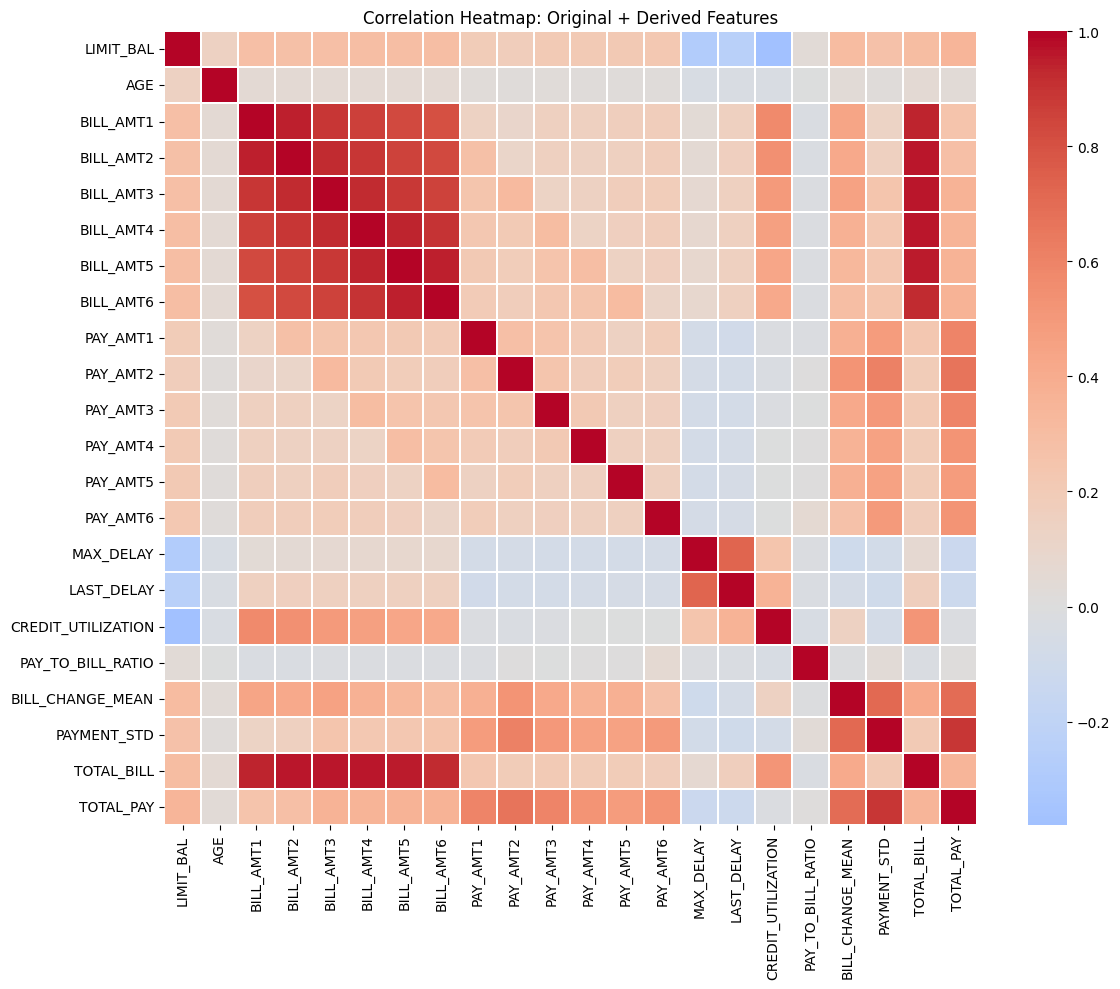

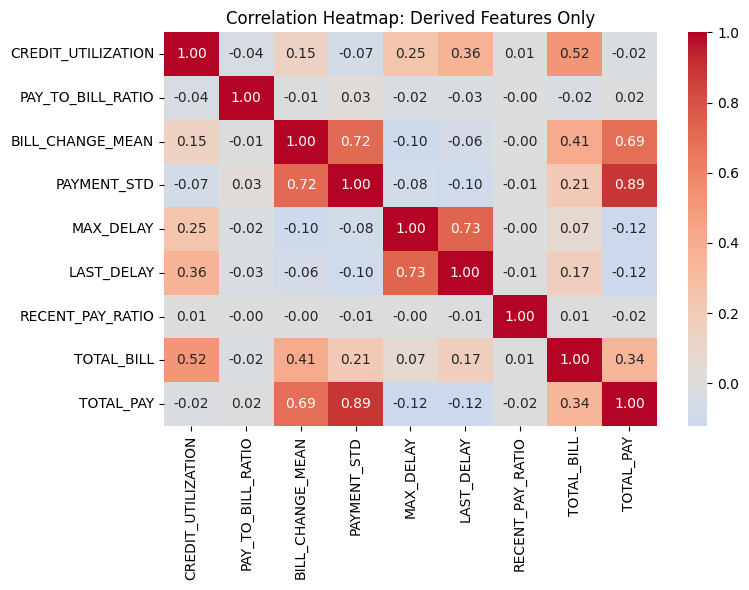

In [ ]:
# Correlation Heatmap (Original + Derived Features)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./result/uci_default_cleaned.csv")

# 選取主要數值欄位（可依實際需要調整）
numeric_cols = [
    "LIMIT_BAL", "AGE",
    "BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
    "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
    "MAX_DELAY","LAST_DELAY",
    "CREDIT_UTILIZATION","PAY_TO_BILL_RATIO","BILL_CHANGE_MEAN",
    "PAYMENT_STD","TOTAL_BILL","TOTAL_PAY"
]

# 計算相關係數矩陣
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0, linewidths=0.3)
plt.title("Correlation Heatmap: Original + Derived Features")
plt.tight_layout()
plt.show()

derived_only = [
    "CREDIT_UTILIZATION", "PAY_TO_BILL_RATIO", "BILL_CHANGE_MEAN",
    "PAYMENT_STD", "MAX_DELAY", "LAST_DELAY", "RECENT_PAY_RATIO",
    "TOTAL_BILL", "TOTAL_PAY"
]
plt.figure(figsize=(8,6))
sns.heatmap(df[derived_only].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Derived Features Only")
plt.tight_layout()
plt.show()


# XGBoost Model（賴）

C:\Users\Lab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 步驟 1: 讀取資料 ---
資料讀取成功！
資料筆數: 29965, 欄位數: 33
不平衡比例計算 (scale_pos_weight): 3.5196

--- 步驟 2: 訓練 XGBoost 模型 ---
模型訓練完成！

--- 步驟 3: 尋找最佳門檻 ---
門檻         Precision  Recall     F1-Score  
---------------------------------------------
0.2        0.2694     0.9314     0.4179
0.3        0.3129     0.8469     0.4570
0.4        0.3761     0.7278     0.4959
0.5        0.4577     0.6124     0.5239
0.6        0.5298     0.5294     0.5296
0.7        0.6113     0.4163     0.4953

--- 步驟 4: 最終模型評估 (門檻 = 0.4) ---
AUC Score (判別力): 0.7725
Accuracy (準確率): 0.6726

Confusion Matrix (混淆矩陣):
[[3066 1601]
 [ 361  965]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      4667
           1       0.38      0.73      0.50      1326

    accuracy                           0.67      5993
   macro avg       0.64      0.69      0.63      5993
weighted avg       0.78      0.67      0.70      5993


--- 步驟 5: SHAP 可解釋性圖表 ---
計算 SHAP 值中...
產生長

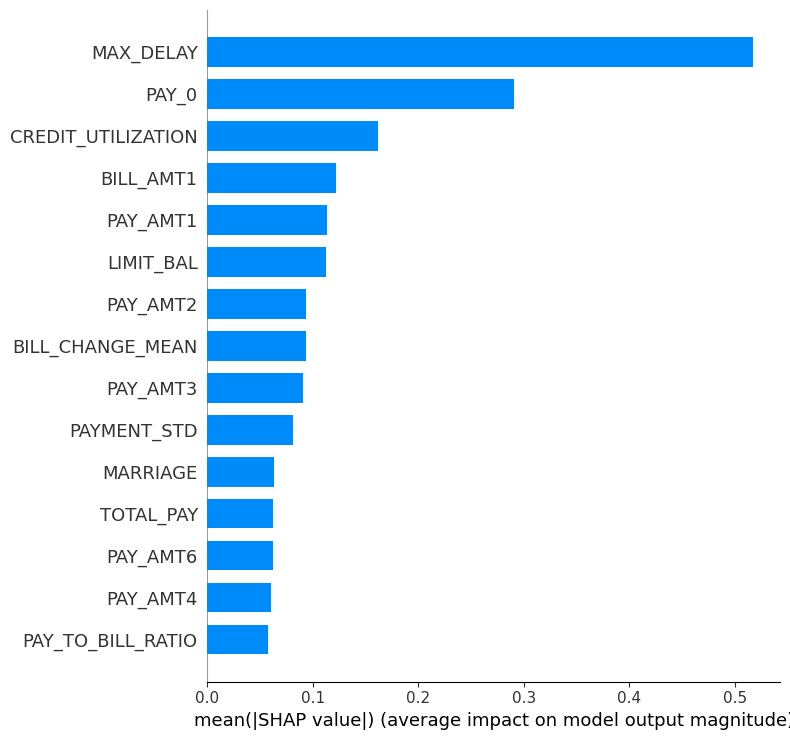

產生蜂群圖...


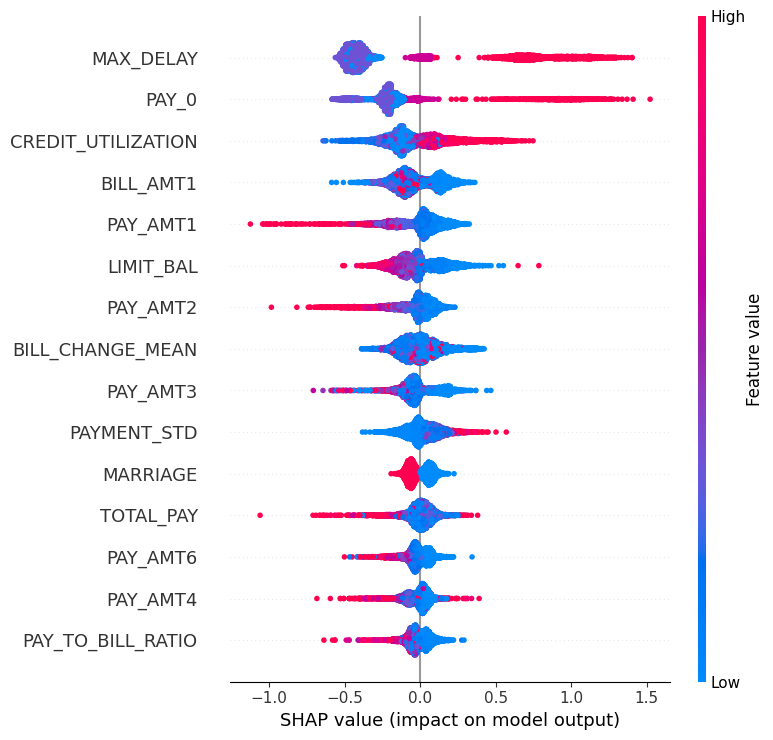

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt

# ==========================================
# 1. 資料讀取與準備
# ==========================================
print("--- 步驟 1: 讀取資料 ---")
try:
    df = pd.read_csv('./result/uci_default_cleaned.csv')
    print("資料讀取成功！")
    print(f"資料筆數: {df.shape[0]}, 欄位數: {df.shape[1]}")
except FileNotFoundError:
    print("錯誤：找不到檔案 'uci_default_cleaned.csv'")
    exit()

# 定義特徵 (X) 與 目標 (y)
target_col = 'default payment next month'
feature_cols = [col for col in df.columns if col != target_col]

X = df[feature_cols]
y = df[target_col]

# 自動計算 scale_pos_weight (處理資料不平衡)
num_neg = (y == 0).sum()
num_pos = (y == 1).sum()
scale_weight = num_neg / num_pos
print(f"不平衡比例計算 (scale_pos_weight): {scale_weight:.4f}")

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 2. 建立與訓練模型
# ==========================================
print("\n--- 步驟 2: 訓練 XGBoost 模型 ---")
model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    scale_pos_weight=scale_weight,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("模型訓練完成！")

# ==========================================
# 3. 敏感度分析 (Threshold Analysis)
# ==========================================
print("\n--- 步驟 3: 尋找最佳門檻 ---")
y_pred_proba = model.predict_proba(X_test)[:, 1]

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

print(f"{'門檻':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 45)

for th in thresholds:
    preds = (y_pred_proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{th:<10} {precision:.4f}     {recall:.4f}     {f1:.4f}")


FINAL_THRESHOLD = 0.4

print(f"\n--- 步驟 4: 最終模型評估 (門檻 = {FINAL_THRESHOLD}) ---")

y_pred_custom = (y_pred_proba >= FINAL_THRESHOLD).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred_custom)

print(f"AUC Score (判別力): {auc:.4f}")
print(f"Accuracy (準確率): {acc:.4f}")
print("\nConfusion Matrix (混淆矩陣):")
print(confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

# ==========================================
# 5. 模型解釋 (SHAP)
# ==========================================
print("\n--- 步驟 5: SHAP 可解釋性圖表 ---")
print("計算 SHAP 值中...")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 圖表 1
print("產生長條圖...")
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=False)
plt.show()

# 圖表 2
print("產生蜂群圖...")
plt.figure()
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.show()

# Logistic Regression Model（黎）

In [ ]:
# 步驟 1: 導入必要的函式庫
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# 步驟 2: 掛載 Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive 掛載完成。")
# from google.colab import drive
# drive.mount('/content/drive')

# 步驟 3: 載入資料
file_path = './result/uci_default_cleaned_scaled.csv'
df = pd.read_csv(file_path)
print(f"資料載入成功，樣本數: {len(df)}")
print("數據前五行：")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 掛載完成。
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
資料載入成功，樣本數: 29965
數據前五行：
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2  \
0  -1.136285    2          2         1 -1.246078  1.943013  1.937323   
1  -0.365619    2          2         2 -1.029141 -1.085092  1.937323   
2  -0.596819    2          2         2 -0.161397 -0.075724  0.006412   
3  -0.905085    2          2         1  0.164007 -0.075724  0.006412   
4  -0.905085    1          2         1  2.333368 -1.085092  0.006412   

      PAY_3     PAY_4     PAY_5  ...  default payment next month  \
0 -0.947406 -0.937152 -0.941082  ...                           1   
1  0.028363  0.075789  0.120847  ...                           1   
2  0.028363  0.075789  0.120847  ...                         

In [ ]:
# 步驟 4: 類別變數編碼 (One-Hot Encoding)
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

# drop_first=True 可避免共線性問題，但對於基準模型 (Logistic Regression) 仍建議使用
# get_dummies 會將 'SEX' 欄位替換為 'SEX_1', 'SEX_2' 等虛擬變數
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
#將 df 中的 categorical_cols 所列的欄位轉換為多個虛擬變數（Dummy Variables）

# 步驟 5: 定義特徵 (X) 和目標變數 (y)
target_col = 'default payment next month' #目標變數
X = df.drop(columns=[target_col]) # 定義特徵矩陣 X（自變數）。從整個 DataFrame df 中移除目標變數欄位 target_col，剩下的就是所有的特徵。
y = df[target_col] #定義目標向量 y（應變數）。只保留 target_col 欄位，即客戶是否違約的標記。

# 步驟 6: 劃分訓練集與測試集
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, # 常用 70% 訓練 / 30% 測試
    random_state=RANDOM_SEED,
    stratify=y # 使用 stratify 確保訓練集和測試集的違約比例一致
)

print("\n資料劃分完成。")
print(f"訓練集樣本數: {len(X_train)} | 測試集樣本數: {len(X_test)}")


資料劃分完成。
訓練集樣本數: 20975 | 測試集樣本數: 8990


In [ ]:
# 步驟 7: 訓練羅吉斯迴歸基準模型
# 使用 class_weight='balanced' 處理資料不平衡
# 由於違約（1）是少數類別，此參數會自動調整類別權重，讓模型更重視對少數類別的預測，以提高召回率。
log_reg_baseline = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000 # 確保模型收斂
)

print("\n開始訓練羅吉斯迴歸模型...")
log_reg_baseline.fit(X_train, y_train)
print("模型訓練完成。")

# 步驟 8: 預測與效能評估
# 預測違約機率 (用於計算 AUC)
y_pred_proba = log_reg_baseline.predict_proba(X_test)[:, 1]

# 預測類別標籤 (用於計算 Recall/Accuracy)
y_pred = log_reg_baseline.predict(X_test)

# 計算評估指標
auc_score = roc_auc_score(y_test, y_pred_proba) # 專案要求的整體判別力指標
recall = recall_score(y_test, y_pred) # 召回率 (捕捉違約客戶的能力):衡量在所有實際違約客戶中，模型成功預測出違約的比例。
accuracy = accuracy_score(y_test, y_pred) # 準確率:衡量模型預測正確的樣本佔總樣本的比例。

print("\n--- 基準模型效能評估 (測試集) ---")
print(f"AUC (Area Under the Curve): {auc_score:.4f} (判斷力指標)")
print(f"召回率 (Recall Score):     {recall:.4f} (捕捉違約客戶能力)")
print(f"準確率 (Accuracy Score):  {accuracy:.4f}")
print("\n分類報告 (Classification Report):")
print(classification_report(y_test, y_pred)) # 輸出詳細的分類報告，包含 F1-score、精確率（Precision）、召回率（Recall）指標


開始訓練羅吉斯迴歸模型...
模型訓練完成。

--- 基準模型效能評估 (測試集) ---
AUC (Area Under the Curve): 0.7390 (判斷力指標)
召回率 (Recall Score):     0.6315 (捕捉違約客戶能力)
準確率 (Accuracy Score):  0.7283

分類報告 (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      7001
           1       0.42      0.63      0.51      1989

    accuracy                           0.73      8990
   macro avg       0.65      0.69      0.66      8990
weighted avg       0.78      0.73      0.74      8990



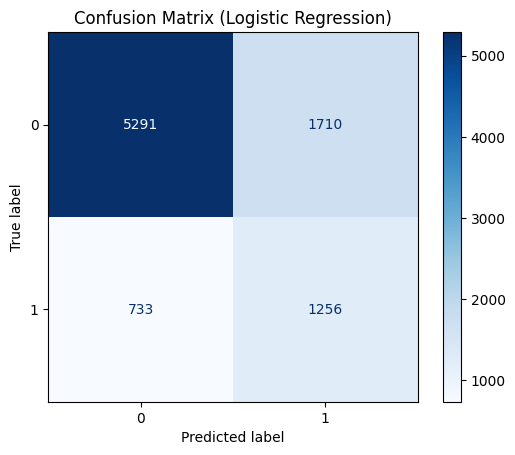

In [ ]:
# --- 繪製混淆矩陣 (Confusion Matrix) ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. 計算混淆矩陣數值
cm = confusion_matrix(y_test, y_pred)

# 2. 設定繪圖物件 (cmap='Blues' 設定為藍色系，與您提供的圖片一致)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d') # values_format='d' 確保顯示整數

# 3. 加入標題並顯示
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

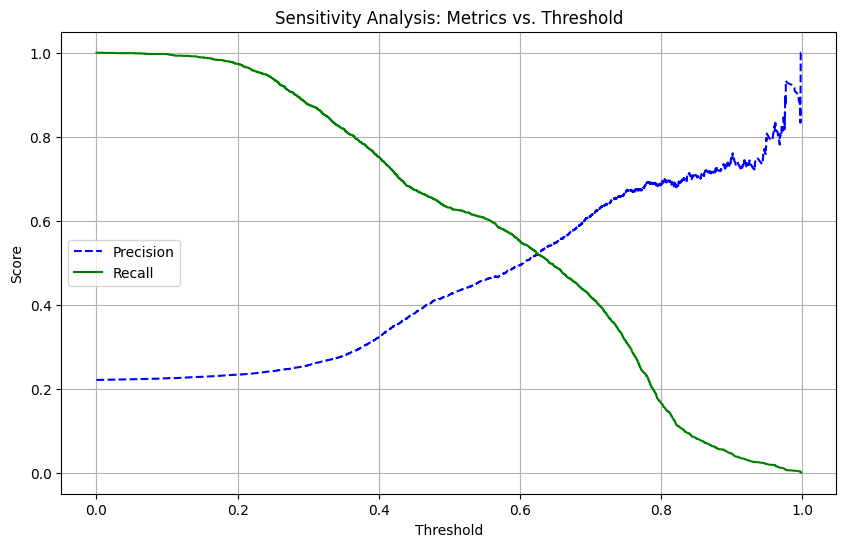

In [ ]:
# --- 新增程式碼：敏感度分析 (Threshold Sensitivity Analysis) ---
from sklearn.metrics import precision_recall_curve

# 1. 取得預測機率
y_pred_proba = log_reg_baseline.predict_proba(X_test)[:, 1]

# 2. 計算不同閥值下的 Precision 和 Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 3. 繪圖
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title("Sensitivity Analysis: Metrics vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="center left")
plt.grid(True)
plt.show()

In [ ]:
# 步驟 9: 係數分析 (模型解釋)
print("\n--- 羅吉斯迴歸係數分析 (特徵影響力與風險方向) ---")

# 獲取係數和特徵名稱
coefficients = log_reg_baseline.coef_[0] #從訓練好的模型中提取所有特徵的係數（w1,w2,..）。係數代表每個特徵對違約風險的影響程度。
feature_names = X_train.columns

# 創建係數 DataFrame 並計算絕對值
# 將特徵名稱和對應的係數組織成一個 DataFrame，方便後續排序和分析
# 計算係數的絕對值。因為影響力（強度）只看絕對值大小，正負號只代表方向。
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# 輸出前 15 大影響特徵
print(f"截距 (Intercept): {log_reg_baseline.intercept_[0]:.4f}")
print("\n前 15 大影響特徵：")
print("（係數的絕對值越大，影響力越大。正值 (+) 表示該特徵增加違約風險，負值 (-) 表示降低違約風險）")

for index, row in coef_df.head(15).iterrows():
    # 根據係數判斷風險方向
    sign = '增加違約風險 (+)' if row['Coefficient'] > 0 else '降低違約風險 (-)'

    # 處理 One-Hot 編碼後的特徵名稱
    feature_display = row['Feature']
    if 'SEX_' in feature_display:
        feature_display = feature_display.replace('SEX_1', 'SEX (男性)')\
                                         .replace('SEX_2', 'SEX (女性)')
    elif 'EDUCATION_' in feature_display:
        feature_display = feature_display.replace('EDUCATION_1', 'EDUCATION (研究所)')\
                                         .replace('EDUCATION_2', 'EDUCATION (大學)')\
                                         .replace('EDUCATION_3', 'EDUCATION (高中)')\
                                         .replace('EDUCATION_4', 'EDUCATION (其他)')
    elif 'MARRIAGE_' in feature_display:
        feature_display = feature_display.replace('MARRIAGE_1', 'MARRIAGE (已婚)')\
                                         .replace('MARRIAGE_2', 'MARRIAGE (單身)')\
                                         .replace('MARRIAGE_3', 'MARRIAGE (其他)')

    print(f"  {feature_display:<30}: {row['Coefficient']:.4f} ({sign})")


--- 羅吉斯迴歸係數分析 (特徵影響力與風險方向) ---
截距 (Intercept): -0.2403

前 15 大影響特徵：
（係數的絕對值越大，影響力越大。正值 (+) 表示該特徵增加違約風險，負值 (-) 表示降低違約風險）
  EDUCATION (其他)                : -0.8141 (降低違約風險 (-))
  PAYMENT_STD                   : 0.6265 (增加違約風險 (+))
  MAX_DELAY                     : 0.4340 (增加違約風險 (+))
  TOTAL_PAY                     : -0.3134 (降低違約風險 (-))
  PAY_AMT1                      : -0.2693 (降低違約風險 (-))
  EDUCATION (研究所)               : 0.2587 (增加違約風險 (+))
  BILL_AMT2                     : 0.2536 (增加違約風險 (+))
  PAY_AMT2                      : -0.2506 (降低違約風險 (-))
  LIMIT_BAL                     : -0.1918 (降低違約風險 (-))
  EDUCATION (大學)                : 0.1895 (增加違約風險 (+))
  PAY_0                         : 0.1888 (增加違約風險 (+))
  LAST_DELAY                    : 0.1888 (增加違約風險 (+))
  PAY_AMT6                      : -0.1818 (降低違約風險 (-))
  CREDIT_UTILIZATION            : -0.1808 (降低違約風險 (-))
  SEX (女性)                      : -0.1793 (降低違約風險 (-))


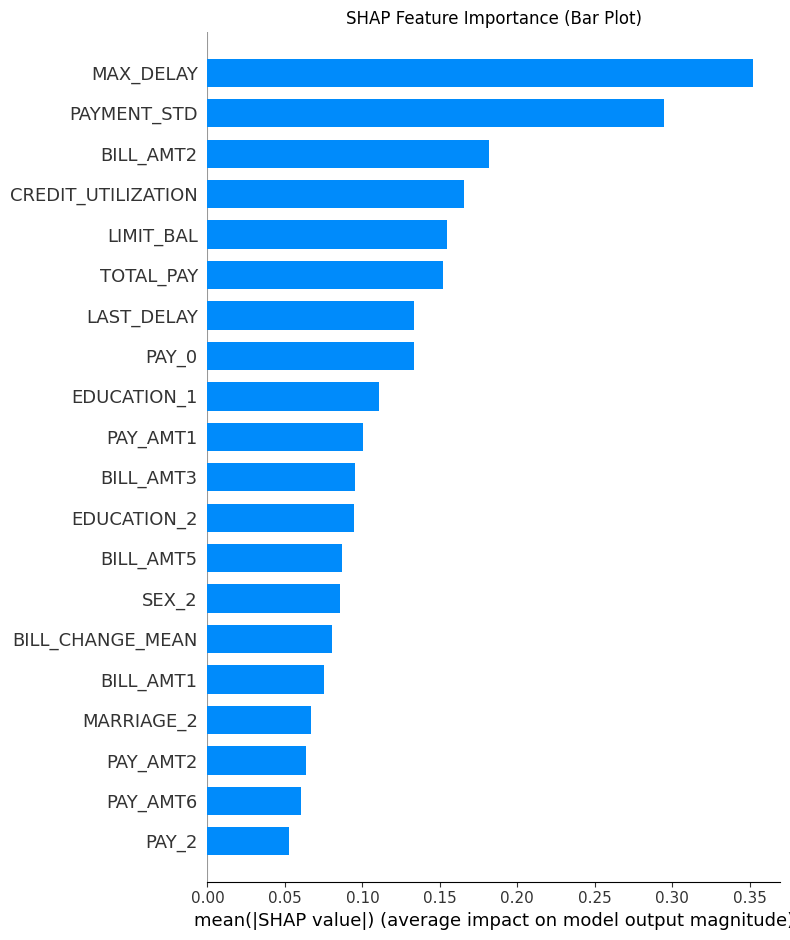

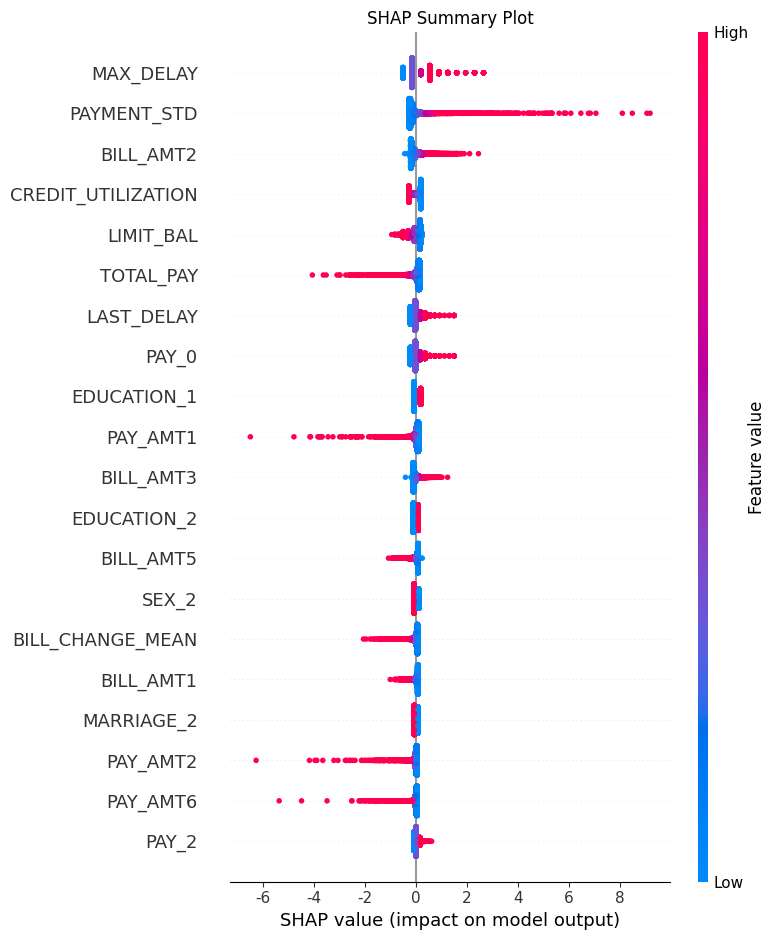

In [ ]:
# --- 步驟 A: 安裝 SHAP 套件 ---
#pip install shap
# --- 步驟 B: 計算 SHAP 值 ---
import shap
import matplotlib.pyplot as plt
import numpy as np

# 確保 X_train 和 X_test 是乾淨且純數值的
# 將 get_dummies 產生的布林值欄位轉換為浮點數 (0 或 1)
X_train_cleaned = X_train.astype(float)
X_test_cleaned = X_test.astype(float)

# 檢查 X_train_cleaned 是否含有 NaN 或 Inf 值，並進行填充
# 雖然資料集已標明 'cleaned_scaled'，但這是一個良好的防禦性編程習慣
if X_train_cleaned.isnull().any().any() or np.isinf(X_train_cleaned).any().any():
    print("Warning: X_train_cleaned contains NaN or Inf values. Attempting to fill with 0.")
    X_train_cleaned = X_train_cleaned.replace([np.inf, -np.inf], np.nan).fillna(0)

# 檢查 X_test_cleaned 是否含有 NaN 或 Inf 值，並進行填充
if X_test_cleaned.isnull().any().any() or np.isinf(X_test_cleaned).any().any():
    print("Warning: X_test_cleaned contains NaN or Inf values. Attempting to fill with 0.")
    X_test_cleaned = X_test_cleaned.replace([np.inf, -np.inf], np.nan).fillna(0)

# 1. 初始化 SHAP 的解釋器 (針對線性模型使用 LinearExplainer)
# log_reg_baseline 是您前面訓練好的模型
# X_train_cleaned 是用來作為背景數據，幫助計算基準值
explainer = shap.LinearExplainer(log_reg_baseline, X_train_cleaned)

# 2. 計算測試集的 SHAP 值
shap_values = explainer.shap_values(X_test_cleaned)

# 檢查 shap_values 是否含有 NaN 或 Inf 值，並在繪圖前進行處理
if isinstance(shap_values, list): # shap_values 對於多輸出模型可能是一個列表
    for i in range(len(shap_values)):
        if np.isnan(shap_values[i]).any() or np.isinf(shap_values[i]).any():
            print(f"Warning: shap_values[{i}] contains NaN or Inf values. Attempting to fill with 0.")
            shap_values[i] = np.nan_to_num(shap_values[i], nan=0.0, posinf=0.0, neginf=0.0)
else: # 如果 shap_values 是一個單一的 numpy 陣列
    if np.isnan(shap_values).any() or np.isinf(shap_values).any():
        print("Warning: shap_values contains NaN or Inf values. Attempting to fill with 0.")
        shap_values = np.nan_to_num(shap_values, nan=0.0, posinf=0.0, neginf=0.0)


# --- 步驟 C: 繪製第一張圖 (特徵重要性排行圖) ---
plt.figure()
plt.title("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test_cleaned, plot_type="bar", show=False) # 使用清理後的 X_test
plt.show()

# --- 步驟 D: 繪製第二張圖 (蜂群圖 Summary Plot) ---
plt.figure()
plt.title("SHAP Summary Plot")
# 這裡使用 X_test_cleaned 作為特徵值來源
shap.summary_plot(shap_values, X_test_cleaned, show=False) # 使用清理後的 X_test
plt.show()

In [ ]:
print("\n--- 對整個資料集進行違約機率預測 ---")
# predict_proba() 返回 (P(class 0), P(class 1)) 的機率陣列
all_proba = log_reg_baseline.predict_proba(X)
# 取出違約 (Class 1) 的預測機率
predicted_prob_default = all_proba[:, 1]

# 步驟 10: 整合結果並生成最終 CSV
# 1. 建立結果 DataFrame
# 假設 DataFrame 的 Index 可以作為客戶識別 (ID)
final_output_df = pd.DataFrame({
    'Client_Index': df.index,  # 使用 DataFrame 的 Index 作為客戶 ID (如果原始資料沒有 ID 欄位)
    'Actual_Default_Label': y, # 實際的違約標籤 (0 或 1)
    'Predicted_Prob_Default': predicted_prob_default # 羅吉斯迴歸預測的違約機率 (0.00 ~ 1.00)
})

# 2. 為了專題成果展示，可以將機率轉換為一個簡單的風險評分 (例如 0~100 分)
# 這裡使用簡單的反轉機率轉換為風險分數 (分數越高，風險越低)
print(f"最終結果 DataFrame 建立完成，樣本數: {len(final_output_df)}")


# 步驟 11: 儲存最終 CSV 檔案
output_csv_path = './result/Model1_Baseline_Final_All_Predictions.csv'
final_output_df.to_csv(output_csv_path, index=False)
print(f"\n--- 最終違約機率檔案已成功儲存至: {output_csv_path} ---")


--- 對整個資料集進行違約機率預測 ---
最終結果 DataFrame 建立完成，樣本數: 29965

--- 最終違約機率檔案已成功儲存至: /content/drive/MyDrive/fintech_final/Model1_Baseline_Final_All_Predictions.csv ---


# Random Forest Model（劉）

正在載入資料: data/uci_default_cleaned.csv...
正在訓練 Random Forest 模型...
正在尋找最佳閾值...
最佳閾值 (Recall ~ 0.6): 0.44

--- 最終模型評估 (調整閾值後) ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4667
           1       0.46      0.61      0.53      1326

    accuracy                           0.76      5993
   macro avg       0.67      0.71      0.68      5993
weighted avg       0.79      0.76      0.77      5993

繪製 Confusion Matrix...
已儲存: confusion_matrix_final.png


<Figure size 800x800 with 0 Axes>

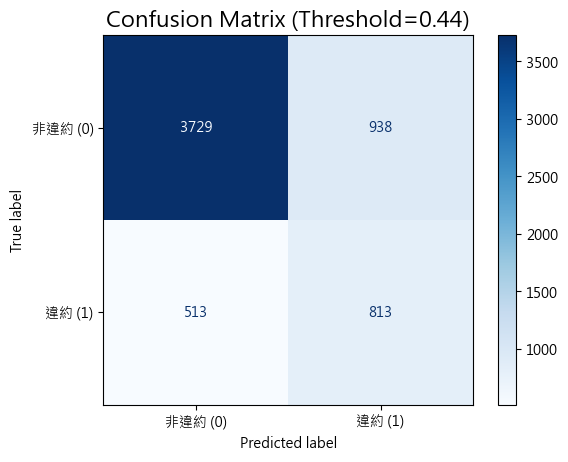

繪製 ROC Curve...
已儲存: roc_curve_final.png


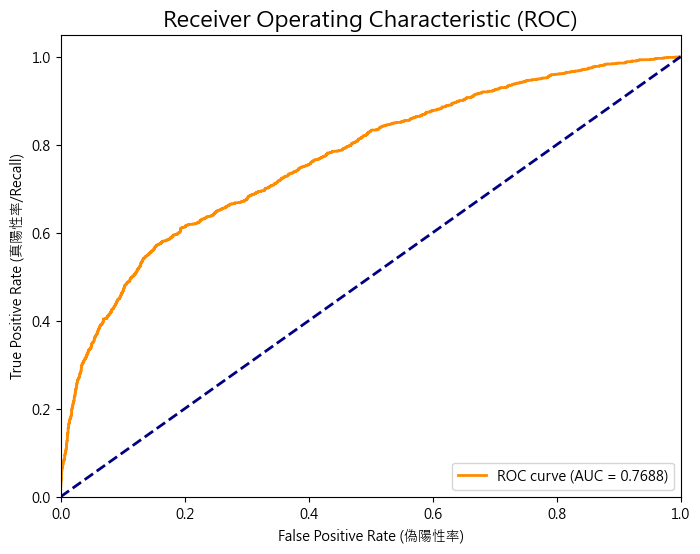


正在計算 SHAP Values...
已儲存: shap_summary_plot.png


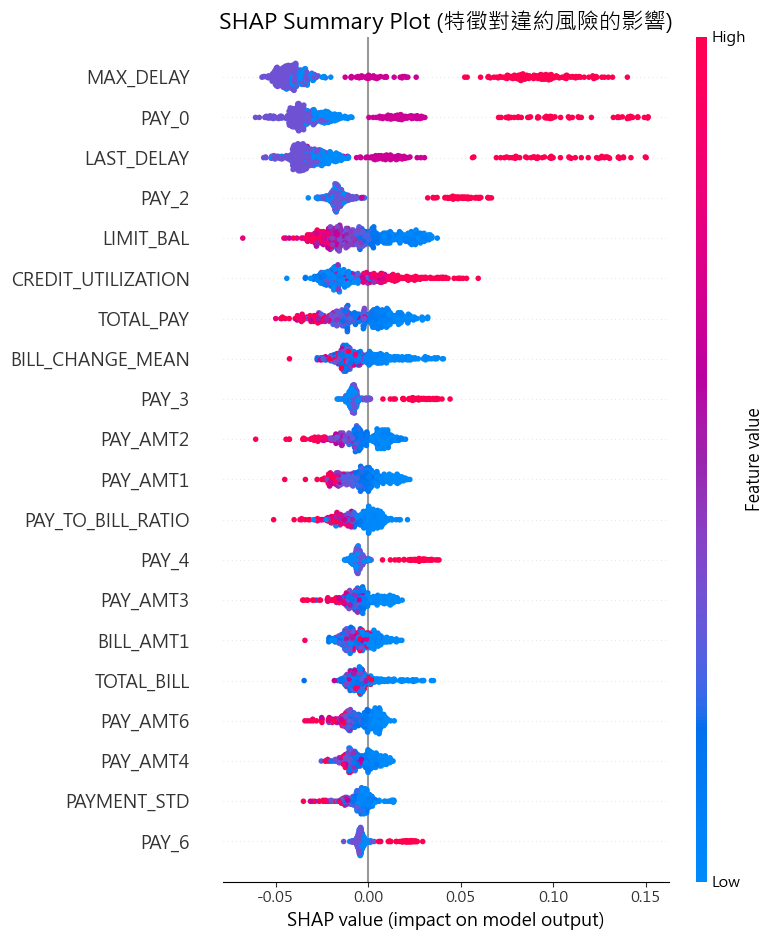

已儲存: shap_importance_bar.png


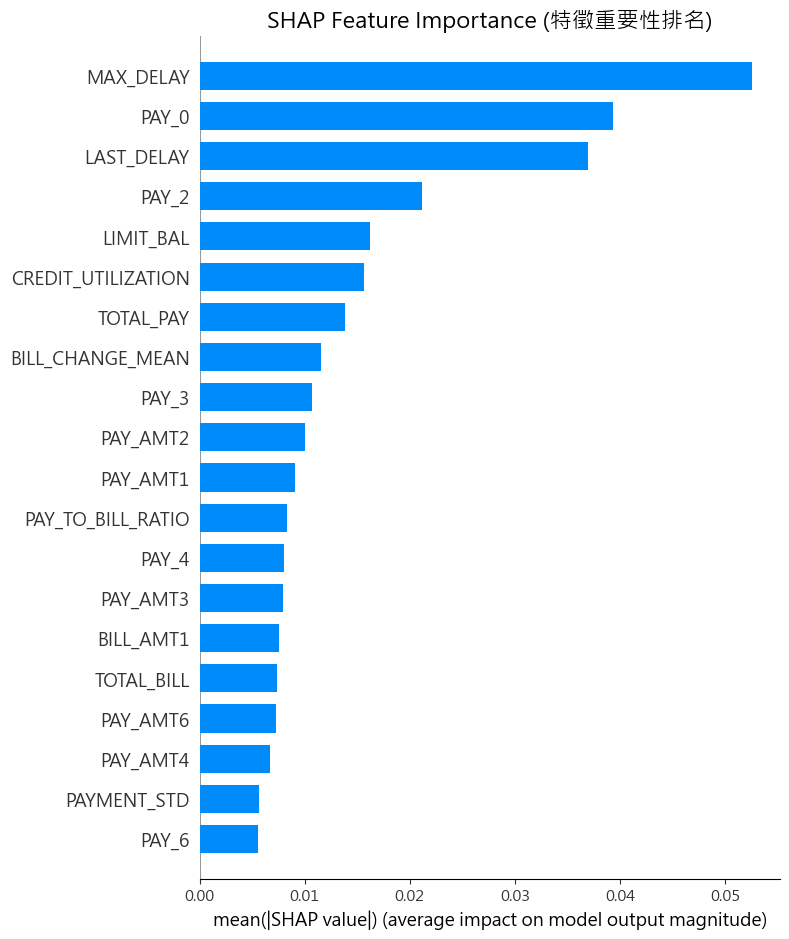


正在進行閾值敏感度分析...
   Threshold    Recall  Precision  Accuracy  F1-Score
0        0.2  0.951735   0.257236  0.381278  0.405006
1        0.3  0.824284   0.321282  0.575838  0.462352
2        0.4  0.658371   0.412961  0.717337  0.507558
3        0.5  0.558069   0.519298  0.787919  0.537986
4        0.6  0.464555   0.569843  0.803938  0.511840
已儲存分析表: threshold_sensitivity_analysis.csv
已儲存比較圖: threshold_comparison.png


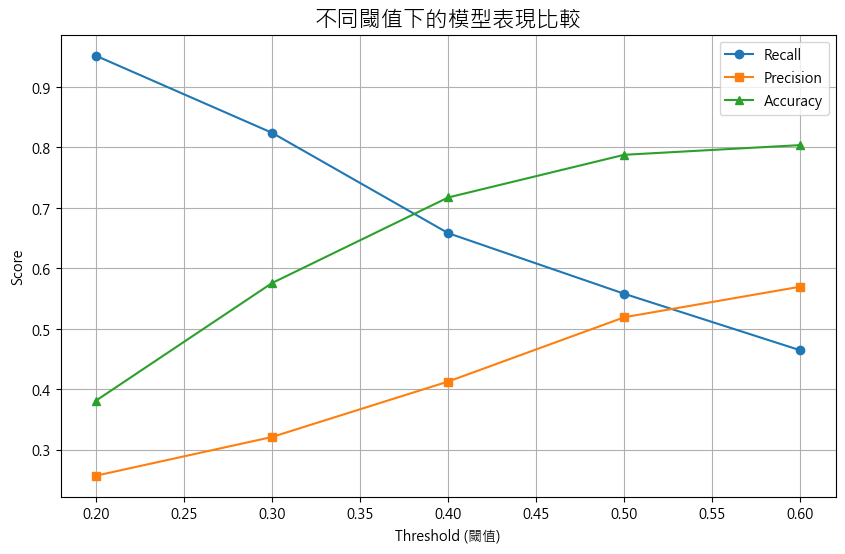

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score, 
    roc_auc_score, precision_recall_curve, precision_score, 
    accuracy_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
)

# 設定中文字型 (選用，若圖表中文顯示亂碼可略過或調整)
# 如果在你的環境中中文仍亂碼，請將此兩行註解掉
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False


# 1. 載入資料
file_path = './result/uci_default_cleaned.csv' 
print(f"正在載入資料: {file_path}...")
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"錯誤：找不到檔案 {file_path}。請確認檔案路徑是否正確。")
    exit()

target = 'default payment next month'
X = df.drop(columns=[target])
y = df[target]

# 2. 切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. 訓練模型
print("正在訓練 Random Forest 模型...")
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    class_weight='balanced', # 處理資料不平衡
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 4. 取得預測機率
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 5. 閾值調整 (找 Recall >= 0.6 的最佳點)
print("正在尋找最佳閾值...")
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
for t in thresholds:
    y_temp_pred = (y_pred_proba >= t).astype(int)
    recall = recall_score(y_test, y_temp_pred)
    if recall < 0.60:
        best_threshold = t - 0.01
        break

print(f"最佳閾值 (Recall ~ 0.6): {best_threshold:.2f}")
y_final_pred = (y_pred_proba >= best_threshold).astype(int)

# 6. 基本評估報告 (使用調整後閾值)
print("\n--- 最終模型評估 (調整閾值後) ---")
print(classification_report(y_test, y_final_pred))


# ==========================================
#  必備圖表生成 (修正版：存檔 + 顯示)
# ==========================================

# 7. Confusion Matrix (混淆矩陣)
print("繪製 Confusion Matrix...")
cm = confusion_matrix(y_test, y_final_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['非違約 (0)', '違約 (1)'])

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})', fontsize=16)

# 1. 先存檔 (設定 dpi=300 讓圖片高清，適合放 PPT)
plt.savefig('./result/confusion_matrix_final.png', dpi=300, bbox_inches='tight')
print("已儲存: confusion_matrix_final.png")

# 2. 再顯示 (讓你在 Notebook 裡直接看到)
plt.show() 


# 8. ROC Curve (ROC 曲線)
print("繪製 ROC Curve...")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (偽陽性率)')
plt.ylabel('True Positive Rate (真陽性率/Recall)')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")

# 存檔 + 顯示
plt.savefig('./result/roc_curve_final.png', dpi=300, bbox_inches='tight')
print("已儲存: roc_curve_final.png")
plt.show()


# ==========================================
#  SHAP Value 分析
# ==========================================
print("\n正在計算 SHAP Values...")

explainer = shap.TreeExplainer(rf_model)
X_test_sample = X_test.iloc[:500] # 僅取前 500 筆加速
shap_values = explainer.shap_values(X_test_sample)

# 取得 Class 1 (違約) 的 SHAP values
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, show=False)
plt.title("SHAP Summary Plot (特徵對違約風險的影響)", fontsize=16)
plt.tight_layout()

# 存檔 + 顯示
plt.savefig('./result/shap_summary_plot.png', dpi=300, bbox_inches='tight')
print("已儲存: shap_summary_plot.png")
plt.show()

# SHAP Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (特徵重要性排名)", fontsize=16)
plt.tight_layout()

# 存檔 + 顯示
plt.savefig('./result/shap_importance_bar.png', dpi=300, bbox_inches='tight')
print("已儲存: shap_importance_bar.png")
plt.show()


# ==========================================
#  閾值敏感度分析圖
# ==========================================
print("\n正在進行閾值敏感度分析...")

thresholds_to_test = [0.2, 0.3, 0.4, 0.5, 0.6]
results = []
for t in thresholds_to_test:
    y_temp_pred = (y_pred_proba >= t).astype(int)
    results.append({
        'Threshold': t,
        'Recall': recall_score(y_test, y_temp_pred),
        'Precision': precision_score(y_test, y_temp_pred),
        'Accuracy': accuracy_score(y_test, y_temp_pred),
        'F1-Score': f1_score(y_test, y_temp_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

results_df.to_csv('./result/threshold_sensitivity_analysis.csv', index=False)
print("已儲存分析表: threshold_sensitivity_analysis.csv")

# 畫出折線圖比較
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df['Threshold'], results_df['Precision'], marker='s', label='Precision')
plt.plot(results_df['Threshold'], results_df['Accuracy'], marker='^', label='Accuracy')
plt.xlabel('Threshold (閾值)')
plt.ylabel('Score')
plt.title('不同閾值下的模型表現比較', fontsize=16)
plt.legend()
plt.grid(True)

# 存檔 + 顯示
plt.savefig('./result/threshold_comparison.png', dpi=300, bbox_inches='tight')
print("已儲存比較圖: threshold_comparison.png")
plt.show()